# โครงงาน Machine Learning: การทำนายปริมาณแคลอรี่ที่เผาผลาญจากการออกกำลังกาย

เอกสาร Jupyter Notebook นี้ นำเสนอขั้นตอนการพัฒนาระบบการเรียนรู้ของเครื่อง (Machine Learning) เพื่อสร้างแบบจำลองสำหรับทำนายปริมาณแคลอรี่ที่ถูกเผาผลาญระหว่างการออกกำลังกาย โดยอาศัยข้อมูลการติดตามการออกกำลังกายของสมาชิกยิม โครงงานนี้จะเน้นการใช้แบบจำลองโครงข่ายประสาทเทียม (Neural Network) ซึ่งสร้างขึ้นด้วยไลบรารี Keras บน TensorFlow

---

# สมาชิก
## 6510742098 tanakrit maenphol
## 6510742254 sorayuth ingboon
## 6510742510 montira innoy

---

## Datasets ที่ใช้ในโครงงานนี้


Dataset : https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset

*ชุดข้อมูลหลักที่ใช้ในโครงงานนี้คือ **"Gym Members Exercise Tracking"** ซึ่งสามารถเข้าถึงได้จากแพลตฟอร์ม Kaggle ผ่าน URL ที่ระบุไว้ข้างต้น*

## การนำเข้าไลบรารีที่จำเป็น

ขั้นตอนแรกในการเริ่มต้นโครงงานคือการนำเข้าไลบรารี (libraries) ต่างๆ ที่จำเป็นสำหรับการจัดการข้อมูล, การคำนวณ, การสร้างแบบจำลอง และการประเมินผล

In [47]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import numpy as np

ไลบรารีหลักที่นำเข้าและบทบาทสำคัญ:
* **`pandas` (as `pd`):** สำหรับการจัดการข้อมูลในรูปแบบตาราง (DataFrame) ซึ่งเป็นโครงสร้างข้อมูลหลักที่ใช้เก็บและประมวลผลชุดข้อมูล
* **`numpy` (as `np`):** สำหรับการคำนวณทางวิทยาศาสตร์ โดยเฉพาะการทำงานกับอาร์เรย์ (arrays) ซึ่งเป็นพื้นฐานของข้อมูลตัวเลขใน Machine Learning
* **`sklearn.model_selection.train_test_split`:** ฟังก์ชันสำหรับแบ่งชุดข้อมูลออกเป็นชุดสำหรับฝึกสอน (training set) และชุดสำหรับทดสอบ (testing set) เพื่อประเมินประสิทธิภาพของโมเดลบนข้อมูลที่ไม่เคยเห็นมาก่อน
* **`sklearn.preprocessing.StandardScaler`:** คลาสสำหรับปรับสเกลข้อมูล (feature scaling) โดยการทำให้แต่ละ feature มีค่าเฉลี่ยเป็น 0 และส่วนเบี่ยงเบนมาตรฐานเป็น 1 ซึ่งช่วยให้โมเดล Neural Network ฝึกสอนได้ดีขึ้น
* **`sklearn.metrics.mean_squared_error`, `r2_score`:** ฟังก์ชันสำหรับคำนวณตัวชี้วัดประสิทธิภาพของแบบจำลอง Regression เช่น Mean Squared Error (MSE) และ R-squared (R²)
* **`sklearn.linear_model` (`LinearRegression`, `Lasso`, `Ridge`):** แม้โครงงานนี้จะเน้น Neural Network การนำเข้าโมเดลเชิงเส้นเหล่านี้อาจมีไว้สำหรับการทดลองเปรียบเทียบเบื้องต้นหรือเป็น baseline model

## การโหลดและสำรวจชุดข้อมูลเบื้องต้น

เริ่มต้นด้วยการโหลดชุดข้อมูลจากไฟล์ CSV และทำการตรวจสอบโครงสร้างและเนื้อหาเบื้องต้นเพื่อให้เข้าใจลักษณะของข้อมูล ซึ่งเป็นขั้นตอนสำคัญในการวางแผนการเตรียมข้อมูลต่อไป

### โหลดชุดข้อมูลจากไฟล์ CSV

In [48]:
data = pd.read_csv("/content/gym_members_exercise_tracking.csv")
data.shape

(973, 15)

## การเตรียมข้อมูลและการวิเคราะห์ข้อมูลเบื้องต้น (Data Preparation and EDA)

ก่อนที่จะนำข้อมูลไปใช้ฝึกสอนแบบจำลอง Machine Learning ข้อมูลดิบจำเป็นต้องผ่านกระบวนการเตรียมข้อมูล (Preprocessing) หลายขั้นตอน เพื่อให้ข้อมูลอยู่ในรูปแบบที่เหมาะสมและมีคุณภาพ ซึ่งจะช่วยให้แบบจำลองสามารถเรียนรู้ได้อย่างมีประสิทธิภาพ นอกจากนี้ เราจะทำการวิเคราะห์ข้อมูลเบื้องต้น (Exploratory Data Analysis - EDA) เพื่อทำความเข้าใจลักษณะของข้อมูล ความสัมพันธ์ระหว่างตัวแปร และระบุปัญหาที่อาจเกิดขึ้น

ขั้นตอนเหล่านี้รวมถึง:
*   **การทำความสะอาดข้อมูล (Data Cleaning):** จัดการกับค่าที่หายไป, ข้อมูลผิดปกติ (outliers), และความไม่สอดคล้องกันของข้อมูล
*   **การแปลงคุณลักษณะ (Feature Transformation):** การแปลงข้อมูลให้อยู่ในรูปแบบที่เหมาะสมสำหรับแบบจำลอง เช่น การทำ One-Hot Encoding สำหรับข้อมูลประเภท Categorical
*   **การปรับสเกลข้อมูล (Data Scaling):** การปรับช่วงค่าของข้อมูลให้อยู่ในสเกลเดียวกัน ซึ่งสำคัญสำหรับแบบจำลองบางประเภท เช่น Neural Network
*   **การวิเคราะห์ข้อมูลเบื้องต้น (EDA):** การใช้ภาพ (Visualization) และสถิติเชิงพรรณนา (Descriptive Statistics) เพื่อสำรวจและทำความเข้าใจข้อมูล

### การแปลงคุณลักษณะ (Feature Transformation):

แบบจำลอง Machine Learning ส่วนใหญ่ (โดยเฉพาะโครงข่ายประสาทเทียม) ต้องการข้อมูลนำเข้าที่เป็นตัวเลขทั้งหมด ดังนั้นคุณลักษณะที่เป็นกลุ่ม (Categorical) เช่น `Gender` จะต้องถูกแปลงให้อยู่ในรูปแบบตัวเลข ในที่นี้เราจะใช้เทคนิค One-Hot Encoding ซึ่งเป็นวิธีที่นิยมใช้ในการจัดการกับคุณลักษณะประเภทนี้

In [49]:
data = pd.get_dummies(data, columns=['Gender'])
data = data.drop(columns=['Gender_Female', 'Workout_Type'], axis=1)
data['Gender_Male'] = data['Gender_Male'].astype(int)
data

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Male
0,56,88.3,1.71,180,157,60,1.69,1313.0,12.6,3.5,4,3,30.20,1
1,46,74.9,1.53,179,151,66,1.30,883.0,33.9,2.1,4,2,32.00,0
2,32,68.1,1.66,167,122,54,1.11,677.0,33.4,2.3,4,2,24.71,0
3,25,53.2,1.70,190,164,56,0.59,532.0,28.8,2.1,3,1,18.41,1
4,38,46.1,1.79,188,158,68,0.64,556.0,29.2,2.8,3,1,14.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,87.1,1.74,187,158,67,1.57,1364.0,10.0,3.5,4,3,28.77,1
969,25,66.6,1.61,184,166,56,1.38,1260.0,25.0,3.0,2,1,25.69,1
970,59,60.4,1.76,194,120,53,1.72,929.0,18.8,2.7,5,3,19.50,0
971,32,126.4,1.83,198,146,62,1.10,883.0,28.2,2.1,3,2,37.74,1


ในส่วนนี้ เราจะใช้ Interquartile Range (IQR) เพื่อระบุและกำจัดข้อมูลผิดปกติ (outliers) ออกจากชุดข้อมูล

1.  **คำนวณควอร์ไทล์ที่ 1 (Q1) และควอร์ไทล์ที่ 3 (Q3):**
    เราใช้เมธอด `quantile()` ของ pandas DataFrame เพื่อหาค่า Q1 (เปอร์เซ็นไทล์ที่ 25) และ Q3 (เปอร์เซ็นไทล์ที่ 75) สำหรับแต่ละคอลัมน์ที่เป็นตัวเลขใน DataFrame `data`

2.  **คำนวณ Interquartile Range (IQR):**
    IQR คือส่วนต่างระหว่าง Q3 และ Q1 (`IQR = Q3 - Q1`) ซึ่งเป็นช่วงที่ครอบคลุมข้อมูลส่วนกลาง 50%

3.  **ระบุ Outliers:**
    เราใช้สูตร `(data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)` เพื่อสร้าง boolean mask สำหรับระบุ outliers ข้อมูลจะถูกพิจารณาว่าเป็น outlier หากมีค่าน้อยกว่า `Q1 - 1.5 * IQR` หรือมากกว่า `Q3 + 1.5 * IQR`

4.  **กรองข้อมูล:**
    สุดท้าย เราใช้ boolean mask ที่สร้างขึ้นเพื่อกรองแถวที่มี outliers ออกจาก DataFrame `data` โดยใช้ `~(outlier).any(axis=1)` ซึ่งหมายถึงเก็บเฉพาะแถวที่ไม่มีค่าใดๆ ในแถวนั้นเป็น outlier

In [50]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

IQR = Q3 - Q1
outlier = ((data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR))
data = data[~(outlier).any(axis=1)]

In [51]:
#pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(12, 12))

สร้าง Boxplot เพื่อแสดงความสัมพันธ์ระหว่างเพศ (`Gender_Male`) กับปริมาณแคลอรี่ที่ถูกเผาผลาญ (`Calories_Burned`)


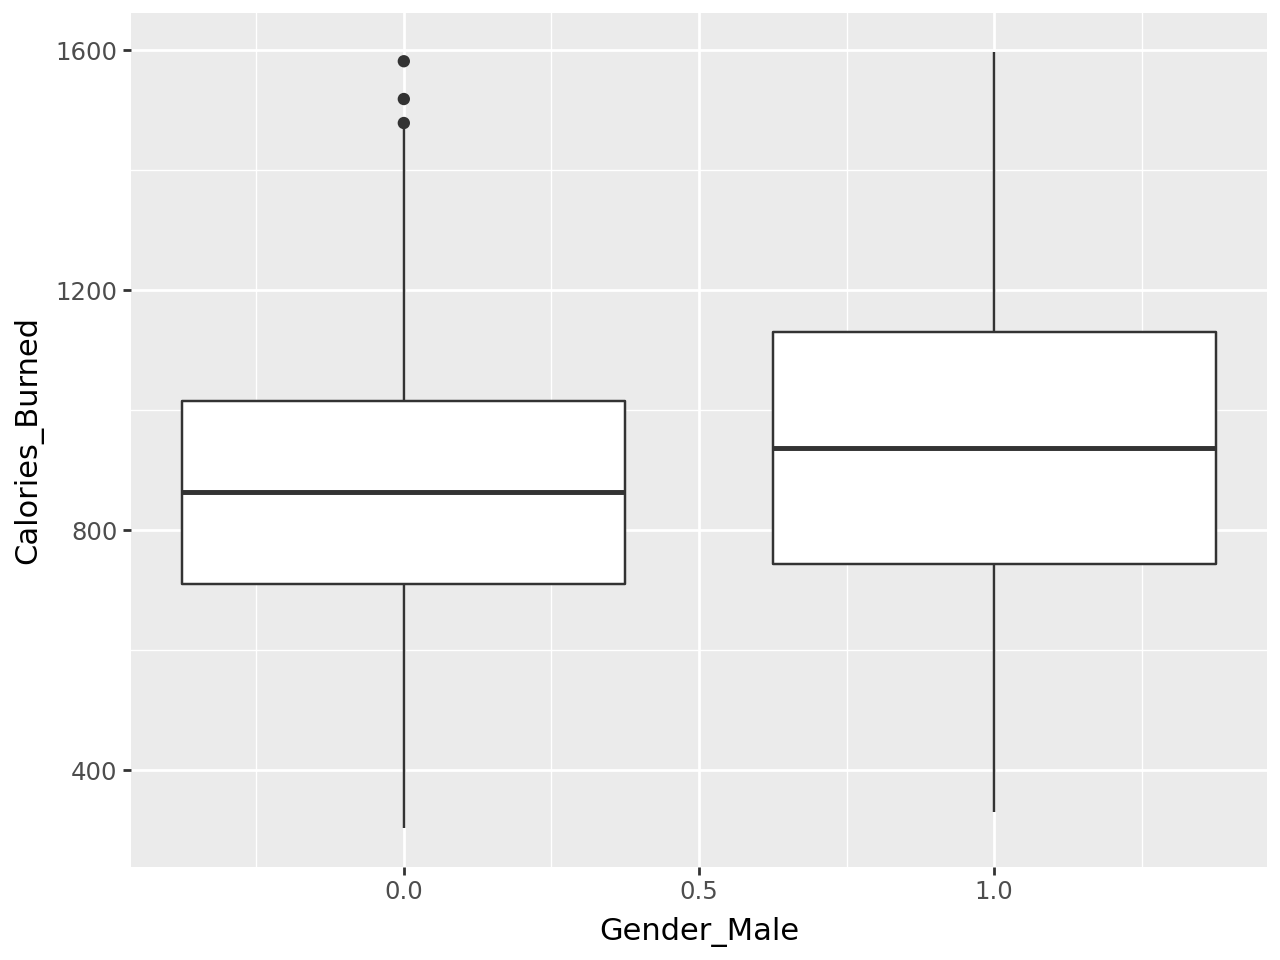

In [52]:
plt = ggplot(data, aes(x="Gender_Male", y="Calories_Burned", group="Gender_Male")) + geom_boxplot()
display(plt)

สร้าง Scatter Plot เพื่อแสดงความสัมพันธ์ระหว่างระยะเวลาการออกกำลังกาย (`Session_Duration (hours)`) กับปริมาณแคลอรี่ที่ถูกเผาผลาญ (`Calories_Burned`) พร้อมกับเส้นแนวโน้มเชิงเส้น (Linear Regression)

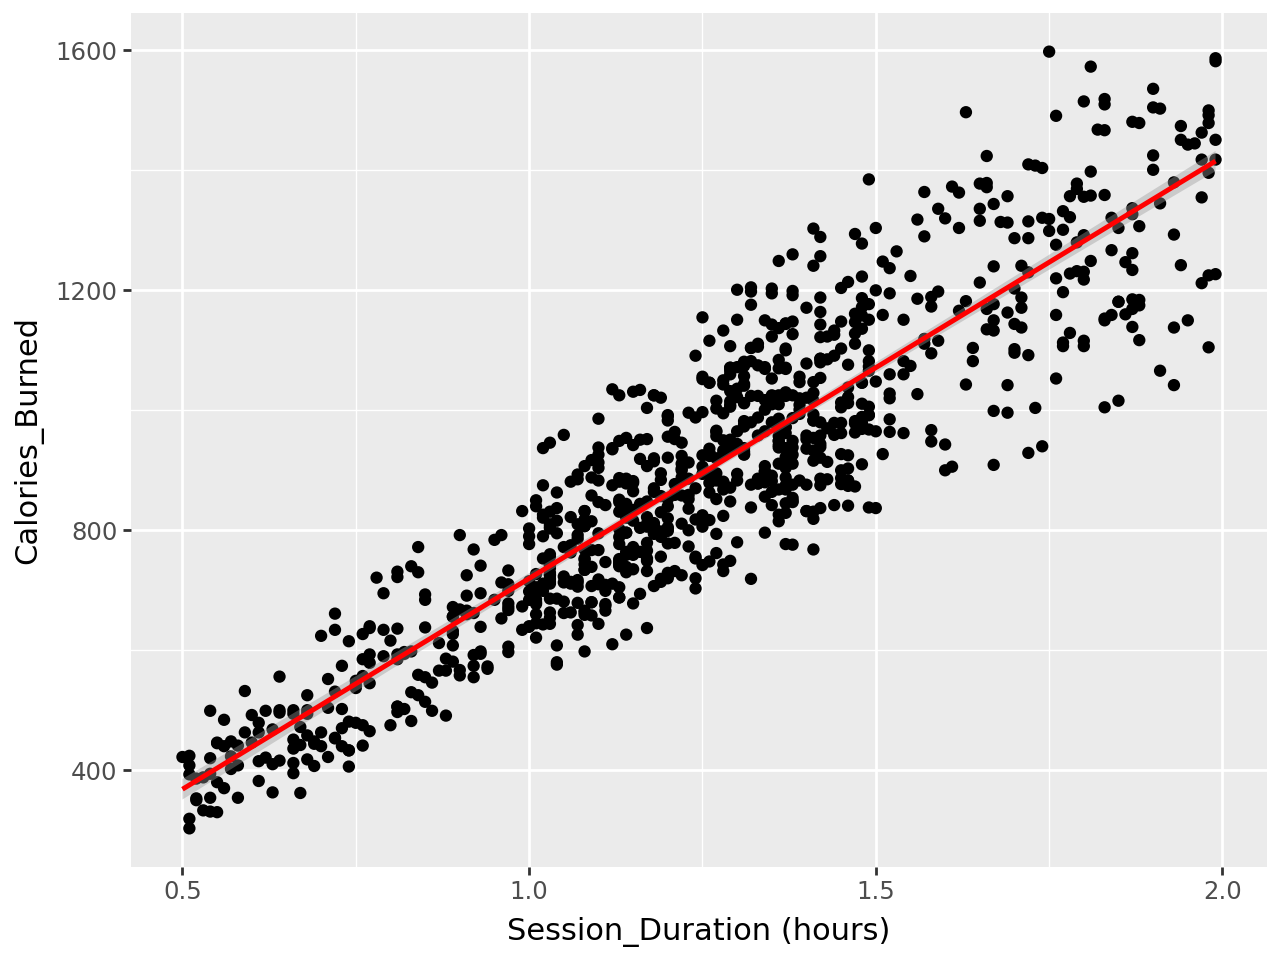

In [53]:
plt = ggplot(data, aes(x="Session_Duration (hours)", y="Calories_Burned")) + geom_point() + geom_smooth(method='lm', color='red')
display(plt)

โค้ดส่วนนี้สร้าง Scatter Plot เพื่อแสดงความสัมพันธ์ระหว่างอัตราการเต้นของหัวใจโดยเฉลี่ย (`Avg_BPM`) กับปริมาณแคลอรี่ที่ถูกเผาผลาญ (`Calories_Burned`) พร้อมกับเส้นแนวโน้มเชิงเส้น (Linear Regression)


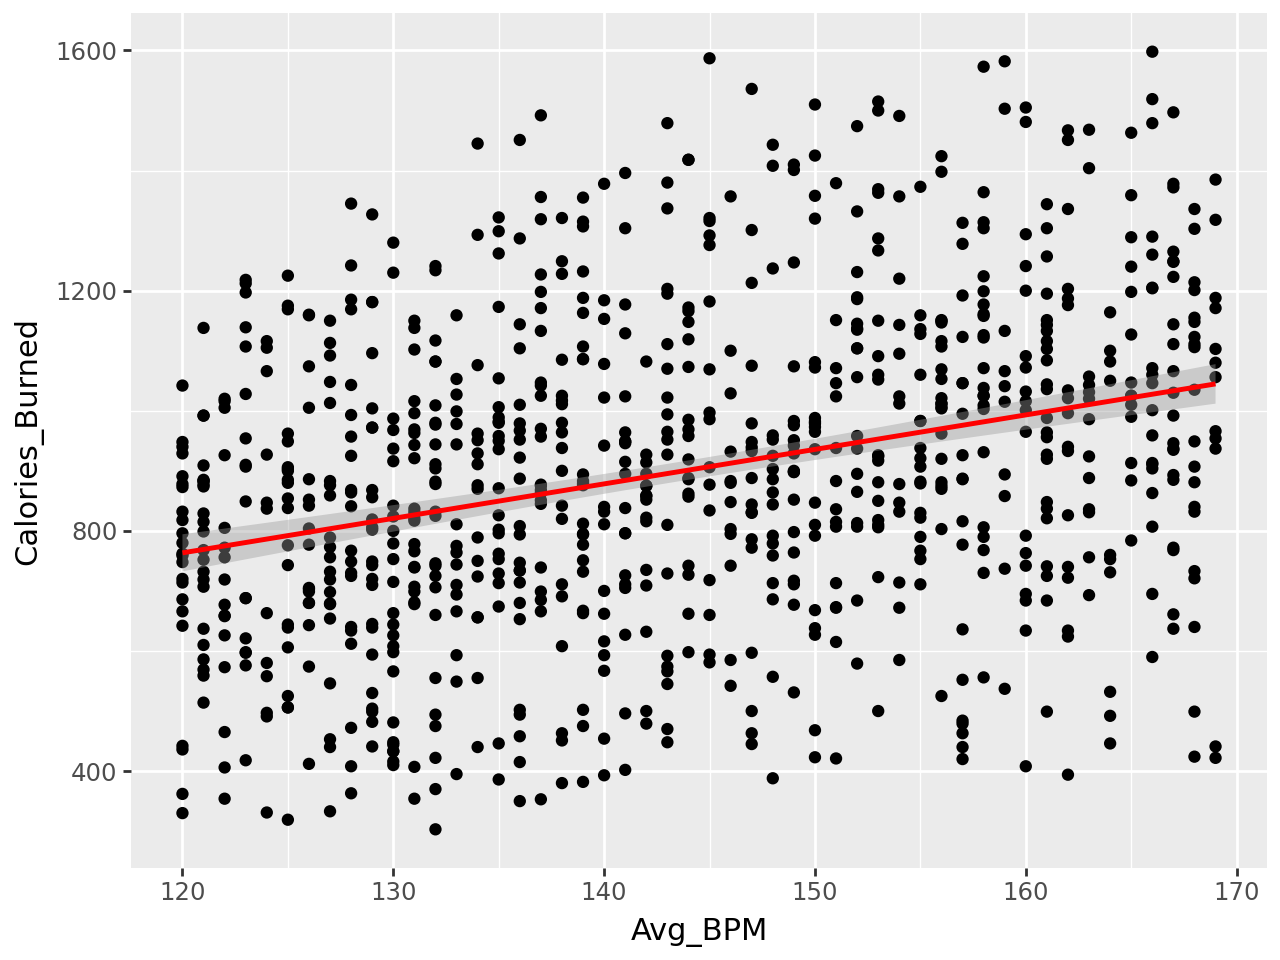

In [54]:
plt = ggplot(data, aes(x="Avg_BPM", y="Calories_Burned")) + geom_point() + geom_smooth(method='lm', color='red')
display(plt)

โค้ดส่วนนี้สร้าง Boxplot เพื่อแสดงความสัมพันธ์ระหว่างระดับประสบการณ์การออกกำลังกาย (`Experience_Level`) กับปริมาณแคลอรี่ที่ถูกเผาผลาญ (`Calories_Burned`)

*   `ggplot(data, aes(x="Experience_Level", y="Calories_Burned", group="Experience_Level"))`: เริ่มต้นการสร้างกราฟโดยระบุ DataFrame ที่ใช้ (`data`) และกำหนดแกน x เป็น `Experience_Level` และแกน y เป็น `Calories_Burned` การกำหนด `group="Experience_Level"` จะทำให้ Boxplot แยกตามระดับประสบการณ์
*   `+ geom_boxplot()`: เพิ่มชั้นของ Boxplot ลงในกราฟ Boxplot จะแสดงค่ามัธยฐาน (median), ควอร์ไทล์ที่ 1 และ 3 (Q1, Q3), และค่าสูงสุด/ต่ำสุดที่ไม่ใช่ outlier รวมถึง outlier ที่อาจมีอยู่ในข้อมูล
*   `display(plt)`: แสดงกราฟที่สร้างขึ้น

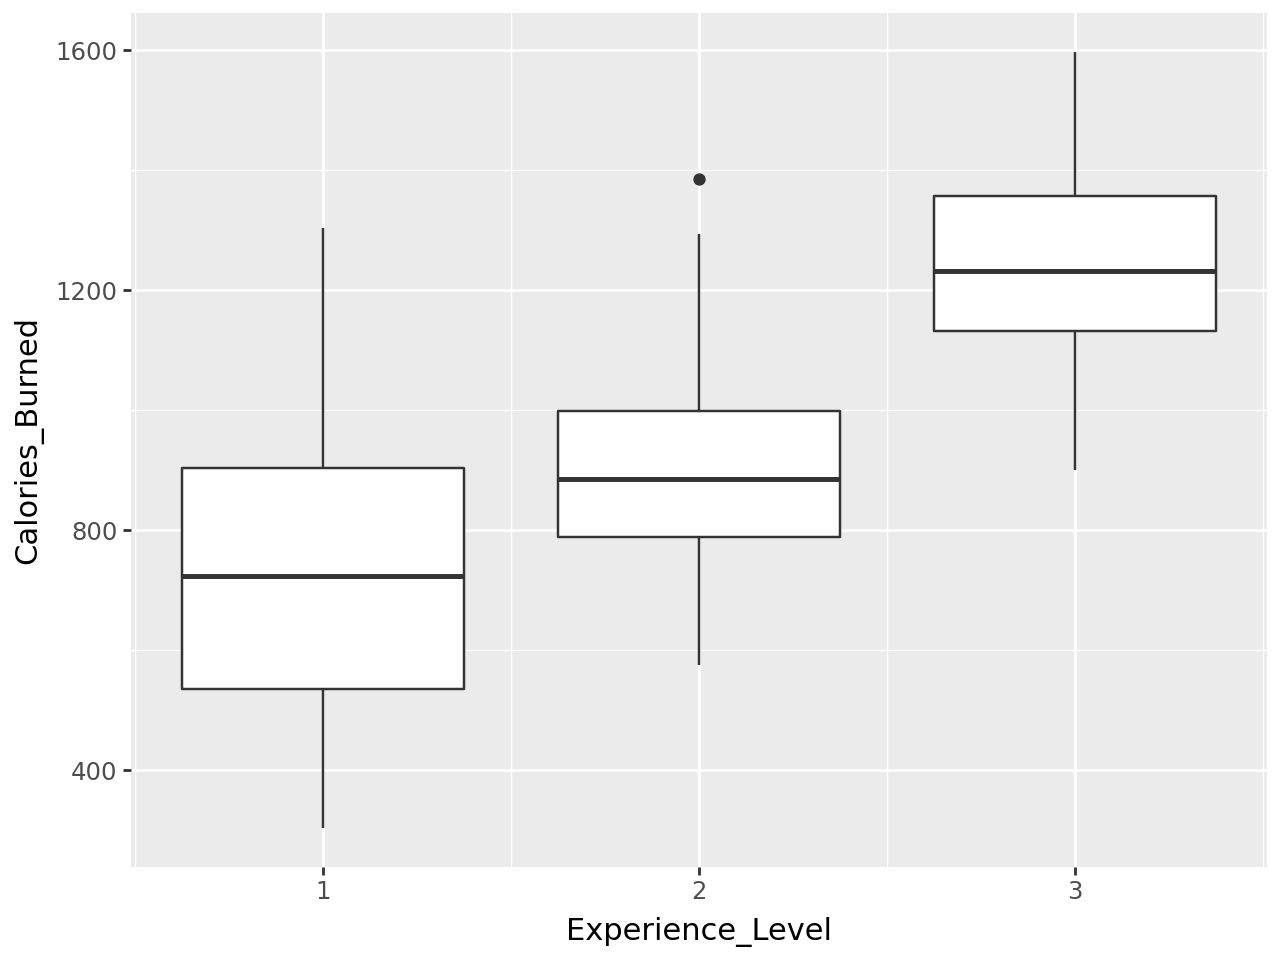

In [55]:
plt = ggplot(data, aes(x="Experience_Level", y="Calories_Burned", group="Experience_Level")) + geom_boxplot()
display(plt)

### การแบ่งชุดข้อมูลสำหรับฝึกสอนและทดสอบ (Train-Test Split)

เพื่อให้สามารถประเมินประสิทธิภาพของแบบจำลองบนข้อมูลที่โมเดลไม่เคยเห็นมาก่อนในระหว่างการฝึกสอน (unseen data) เราจะแบ่งชุดข้อมูล `X` และ `y` ออกเป็นสองส่วนหลักๆ คือ ชุดสำหรับฝึกสอน (Training set) และชุดสำหรับทดสอบ (Test set) สัดส่วนที่นิยมใช้คือ 80% สำหรับ Training set และ 20% สำหรับ Test set

In [56]:
X = data.drop('Calories_Burned', axis=1)
y = data['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

โค้ดส่วนนี้สร้าง dictionary ชื่อ `models` เพื่อเก็บแบบจำลอง Regression ชนิดต่างๆ ที่ต้องการนำมาเปรียบเทียบประสิทธิภาพ

แต่ละ key ใน dictionary คือชื่อของแบบจำลอง ส่วน value คือ instance ของแบบจำลองนั้นๆ จากไลบรารี `sklearn.linear_model`:

*   `'Linear Regression'`: แบบจำลอง Linear Regression พื้นฐาน
*   `'Lasso (alpha=X)'`: แบบจำลอง Lasso Regression ซึ่งเป็นการถดถอยแบบ Regularization ที่ใช้ L1 penalty โดยมีการปรับค่า hyperparameter `alpha` เพื่อควบคุมความเข้มข้นของการปรับค่าสัมประสิทธิ์
*   `'Ridge (alpha=X)'`: แบบจำลอง Ridge Regression ซึ่งเป็นการถดถอยแบบ Regularization ที่ใช้ L2 penalty โดยมีการปรับค่า hyperparameter `alpha` เช่นกัน

การเก็บแบบจำลองใน dictionary ช่วยให้สามารถวนลูปเพื่อฝึกสอนและประเมินผลแบบจำลองแต่ละตัวได้อย่างสะดวกในขั้นตอนถัดไป

In [57]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso (alpha=1.0)': Lasso(alpha=1.0),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0),
    'Lasso (alpha=0.75)': Lasso(alpha=0.75),
    'Ridge (alpha=0.75)': Ridge(alpha=0.75),
    'Lasso (alpha=0.5)': Lasso(alpha=0.5),
    'Ridge (alpha=0.5)': Ridge(alpha=0.5),
    'Lasso (alpha=0.28)': Lasso(alpha=0.28),
    'Ridge (alpha=0.28)': Ridge(alpha=0.28),
}

โค้ดส่วนนี้ทำการฝึกสอนและประเมินประสิทธิภาพของแบบจำลอง Regression แต่ละตัวที่อยู่ใน dictionary `models` โดยใช้วิธีดังนี้:

1.  วนลูปผ่านแต่ละแบบจำลอง
2.  ฝึกสอนแบบจำลองด้วยข้อมูลฝึกสอน (`X_train`, `y_train`)
3.  ทำนายค่า `y` บนข้อมูลทดสอบ (`X_test`)
4.  คำนวณตัวชี้วัดประสิทธิภาพ: Mean Squared Error (MSE) และ R-squared (R²) บนชุดทดสอบ
5.  ทำการ Cross-Validation 5-Fold บนข้อมูลทั้งหมด (`X`, `y`) เพื่อคำนวณค่าเฉลี่ย R²
6.  เก็บผลลัพธ์ที่ได้ (ชื่อแบบจำลอง, MSE, R² บน Test Set, และค่าเฉลี่ย R² จาก CV) ไว้ใน list ชื่อ `results`
7.  พิมพ์ผลลัพธ์สำหรับแต่ละแบบจำลองออกทางหน้าจอ

เมื่อทำงานเสร็จสิ้น จะได้ list `results` ที่มีผลการประเมินของทุกแบบจำลอง

In [58]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    cv_mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    average_cv_mse = -cv_mse_scores.mean()

    cv_r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    average_cv_r2 = cv_r2_scores.mean()

    results.append({
        'Model': name,
        'Test MSE': mse,
        'Test R2': r2,
        'Average CV MSE': average_cv_mse,
        'Average CV R2': average_cv_r2
    })

    print(f"\n{name} Results:")
    print(f'Mean Squared Error on Test Set: {mse}')
    print(f'R-squared (R2) on Test Set: {r2}')
    print(f'Average Mean Squared Error from Cross-Validation: {average_cv_mse}')
    print(f'Average R2 from Cross-Validation: {average_cv_r2}')

results_df = pd.DataFrame(results)
display(results_df)


Linear Regression Results:
Mean Squared Error on Test Set: 1466.2668679172748
R-squared (R2) on Test Set: 0.9804808115176868
Average Mean Squared Error from Cross-Validation: 1438.3796026305765
Average R2 from Cross-Validation: 0.9791800400416795

Lasso (alpha=1.0) Results:
Mean Squared Error on Test Set: 1517.3314335502748
R-squared (R2) on Test Set: 0.9798010315245852
Average Mean Squared Error from Cross-Validation: 1469.5701065801634
Average R2 from Cross-Validation: 0.9787596140588587

Ridge (alpha=1.0) Results:
Mean Squared Error on Test Set: 1496.055030002835
R-squared (R2) on Test Set: 0.9800842665482736
Average Mean Squared Error from Cross-Validation: 1461.3947971687503
Average R2 from Cross-Validation: 0.9788505665864538

Lasso (alpha=0.75) Results:
Mean Squared Error on Test Set: 1503.2160620386962
R-squared (R2) on Test Set: 0.9799889376984617
Average Mean Squared Error from Cross-Validation: 1457.2509709968472
Average R2 from Cross-Validation: 0.9789313005601418

Ridge (

,Model,Test MSE,Test R2,Average CV MSE,Average CV R2
0,Linear Regression,1466.266868,0.980481,1438.379603,0.979180
1,Lasso (alpha=1.0),1517.331434,0.979801,1469.570107,0.978760
2,Ridge (alpha=1.0),1496.055030,0.980084,1461.394797,0.978851
3,Lasso (alpha=0.75),1503.216062,0.979989,1457.250971,0.978931
4,Ridge (alpha=0.75),1486.649678,0.980209,1452.140441,0.978985
5,Lasso (alpha=0.5),1492.317532,0.980134,1448.343438,0.979053
6,Ridge (alpha=0.5),1478.794788,0.980314,1445.016317,0.979088
7,Lasso (alpha=0.28),1485.388185,0.980226,1443.375333,0.979119
8,Ridge (alpha=0.28),1472.964206,0.980392,1440.623684,0.979150


ส่วนนี้คือผลลัพธ์ที่ได้จากการฝึกสอนและประเมินประสิทธิภาพของแบบจำลอง Regression แต่ละตัวที่ได้สร้างขึ้น โดยแสดงค่าตัวชี้วัดหลักสำหรับแต่ละแบบจำลอง:

*   **Linear Regression Results:** แสดง MSE และ R² สำหรับแบบจำลอง Linear Regression พื้นฐาน
*   **Lasso (alpha=X) Results:** แสดง MSE และ R² สำหรับแบบจำลอง Lasso Regression โดยมีการทดสอบค่า `alpha` ต่างๆ
*   **Ridge (alpha=X) Results:** แสดง MSE และ R² สำหรับแบบจำลอง Ridge Regression โดยมีการทดสอบค่า `alpha` ต่างๆ

สำหรับแต่ละแบบจำลอง จะมีค่า:
*   `Mean Squared Error`: แสดงความแม่นยำของการทำนาย (ค่าน้อยยิ่งดี)
*   `R-squared (R2) on Test Set`: แสดงว่าแบบจำลองอธิบายความแปรปรวนของข้อมูลเป้าหมายบนชุดทดสอบได้ดีเพียงใด (ค่าใกล้ 1 ยิ่งดี)
*   `Average R2 from Cross-Validation`: แสดงประสิทธิภาพเฉลี่ยของแบบจำลองจากการทำ Cross-Validation (ค่าสูงยิ่งดี)

ผลลัพธ์เหล่านี้ช่วยให้เปรียบเทียบและเลือกแบบจำลองที่มีประสิทธิภาพดีที่สุดสำหรับงานนี้

In [59]:
results_df = pd.DataFrame(results)
display(results_df)

,Model,Test MSE,Test R2,Average CV MSE,Average CV R2
0,Linear Regression,1466.266868,0.980481,1438.379603,0.979180
1,Lasso (alpha=1.0),1517.331434,0.979801,1469.570107,0.978760
2,Ridge (alpha=1.0),1496.055030,0.980084,1461.394797,0.978851
3,Lasso (alpha=0.75),1503.216062,0.979989,1457.250971,0.978931
4,Ridge (alpha=0.75),1486.649678,0.980209,1452.140441,0.978985
5,Lasso (alpha=0.5),1492.317532,0.980134,1448.343438,0.979053
6,Ridge (alpha=0.5),1478.794788,0.980314,1445.016317,0.979088
7,Lasso (alpha=0.28),1485.388185,0.980226,1443.375333,0.979119
8,Ridge (alpha=0.28),1472.964206,0.980392,1440.623684,0.979150


ส่วนนี้คือผลลัพธ์ที่ได้จากการฝึกสอนและประเมินประสิทธิภาพของแบบจำลอง Regression แต่ละตัวที่ได้สร้างขึ้น โดยแสดงค่าตัวชี้วัดหลักสำหรับแต่ละแบบจำลอง:

*   **Model:** ชื่อของแบบจำลอง (เช่น Linear Regression, Lasso, Ridge พร้อมค่า alpha ที่ใช้)
*   **MSE:** Mean Squared Error (ค่าน้อยยิ่งดี)
*   **R2:** R-squared Score บน Test Set (ค่าใกล้ 1 ยิ่งดี)
*   **CV_R2:** ค่าเฉลี่ย R-squared จาก Cross-Validation (ค่าสูงยิ่งดีและแสดงความเสถียร)

ตารางนี้ช่วยให้เปรียบเทียบประสิทธิภาพของแบบจำลองแต่ละตัวได้อย่างง่ายดาย ทำให้สามารถเลือกแบบจำลองที่มีผลลัพธ์ดีที่สุดสำหรับการนำไปใช้ต่อไปได้

โค้ดส่วนนี้ทำการเลือกแบบจำลอง Regression ที่มีประสิทธิภาพดีที่สุด โดยพิจารณาจากค่าเฉลี่ย R-squared จาก Cross-Validation (`CV_R2`) จากนั้นนำแบบจำลองที่ดีที่สุดนั้นมาฝึกสอนด้วยข้อมูลฝึกสอนทั้งหมด (`X_train`, `y_train`) และใช้ทำนายผลบนข้อมูลทดสอบ (`X_test`) โดยเก็บผลการทำนายไว้ใน `y_pred_best`

In [60]:
best_model_idx = results_df['Average CV MSE'].argmin()
best_model_name = results_df.iloc[best_model_idx]['Model']
best_model = models[best_model_name]
display(best_model)
display(best_model_name)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

LinearRegression()

'Linear Regression'

In [61]:
final_results = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_pred_best,
    'DifF': abs(y_test - y_pred_best)
})

display(final_results)

,True Values,Predicted Values,DifF
864,1242.0,1278.501688,36.501688
74,777.0,816.952399,39.952399
659,904.0,955.797466,51.797466
528,1107.0,1074.130783,32.869217
736,1598.0,1466.107738,131.892262
...,...,...,...
2,677.0,639.282235,37.717765
871,1025.0,992.989517,32.010483
769,1082.0,1057.968610,24.031390
566,1071.0,1061.646107,9.353893


ส่วนนี้คือ DataFrame ที่แสดงผลการเปรียบเทียบระหว่างค่าจริงของปริมาณแคลอรี่ที่ถูกเผาผลาญ (`True Values`) และค่าที่แบบจำลองที่ดีที่สุดทำนายได้ (`Predicted Values`) บนชุดข้อมูลทดสอบ (`X_test`)

ตารางประกอบด้วยสองคอลัมน์:
*   **True Values:** ค่าปริมาณแคลอรี่ที่ถูกเผาผลาญจริงจากชุดข้อมูลทดสอบ
*   **Predicted Values:** ค่าปริมาณแคลอรี่ที่แบบจำลองที่ดีที่สุดทำนายไว้

การแสดงผลลัพธ์ในรูปแบบนี้ช่วยให้สามารถเห็นความแม่นยำของการทำนายของแบบจำลองบนข้อมูลที่ไม่เคยเห็นมาก่อนได้โดยตรง โดยสามารถเปรียบเทียบค่าจริงกับค่าที่ทำนายได้ในแต่ละแถว

### โค้ดส่วนนี้ใช้แบบจำลองที่ฝึกสอนแล้วทำนายปริมาณแคลอรี่ที่ถูกเผาผลาญสำหรับข้อมูลผู้ใช้งานใหม่หนึ่งรายการ โดยให้ค่า feature ต่างๆ เป็น input เข้าไป

In [62]:
import matplotlib.pyplot as plt

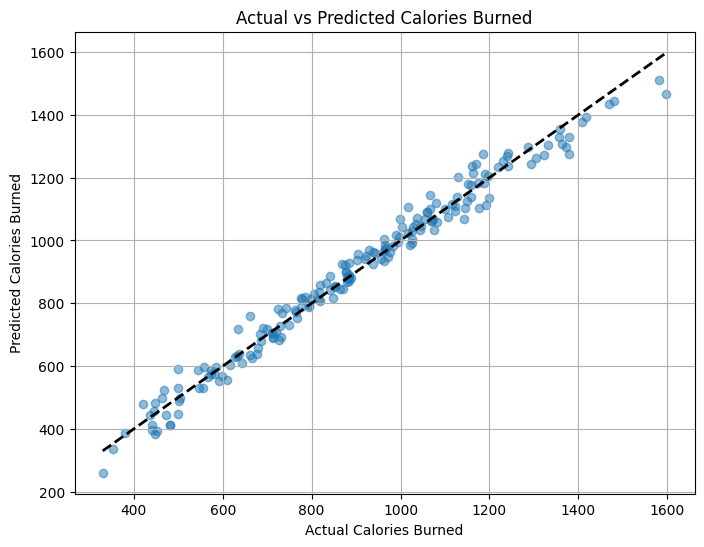

In [63]:
plt.figure(figsize=(8, 6))
plt.scatter(final_results['True Values'], final_results['Predicted Values'], alpha=0.5)

plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.title('Actual vs Predicted Calories Burned')

plt.plot([final_results['True Values'].min(), final_results['True Values'].max()],
         [final_results['True Values'].min(), final_results['True Values'].max()],
         'k--', lw=2)

plt.grid(True)
plt.show()

In [64]:
y_pred = model.predict([[56,	88.3,	1.71,	180,	157,	60,	1.69,	12.6,	3.5,	4,	3,	30.20,	1]])
y_pred

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names


array([1277.03629706])

# การนำ Neural Network มาสร้างแบบจำลองการทำนายปริมาณแคลอรี่ที่เผาผลาญ

## การเตรียมสภาพแวดล้อม: นำเข้าไลบรารีที่จำเป็น

In [65]:
import tensorflow.keras as Keras
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

* **`tensorflow.keras.models.Sequential`:** คลาสสำหรับสร้างแบบจำลองโครงข่ายประสาทเทียมแบบเรียงลำดับชั้น (sequential model) ซึ่งเป็นวิธีที่ง่ายและตรงไปตรงมาในการสร้างโมเดลส่วนใหญ่
* **`tensorflow.keras.layers.Dense`:** คลาสสำหรับสร้างชั้นที่เชื่อมต่อกันอย่างสมบูรณ์ (fully connected layer หรือ dense layer) ซึ่งเป็นองค์ประกอบพื้นฐานของโครงข่ายประสาทเทียมส่วนใหญ่

กำหนดค่า seed สำหรับไลบรารี `random`, `numpy`, และ `tensorflow` เพื่อควบคุมกระบวนการสุ่มต่างๆ ทำให้ผลลัพธ์ที่ได้จากการทำงานซ้ำได้ (reproducible)

In [66]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

###  โหลดชุดข้อมูลจากไฟล์ CSV

In [67]:
data = pd.read_csv("/content/gym_members_exercise_tracking.csv")
data.shape

(973, 15)

### การแปลงคุณลักษณะ (Feature Transformation):

แบบจำลอง Machine Learning ส่วนใหญ่ (โดยเฉพาะโครงข่ายประสาทเทียม) ต้องการข้อมูลนำเข้าที่เป็นตัวเลขทั้งหมด ดังนั้นคุณลักษณะที่เป็นกลุ่ม (Categorical) เช่น `Gender` จะต้องถูกแปลงให้อยู่ในรูปแบบตัวเลข ในที่นี้เราจะใช้เทคนิค One-Hot Encoding ซึ่งเป็นวิธีที่นิยมใช้ในการจัดการกับคุณลักษณะประเภทนี้

In [68]:
data = pd.get_dummies(data, columns=['Gender'])
data = data.drop(columns=['Gender_Female', 'Workout_Type'], axis=1)
data['Gender_Male'] = data['Gender_Male'].astype(int)
data

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Male
0,56,88.3,1.71,180,157,60,1.69,1313.0,12.6,3.5,4,3,30.20,1
1,46,74.9,1.53,179,151,66,1.30,883.0,33.9,2.1,4,2,32.00,0
2,32,68.1,1.66,167,122,54,1.11,677.0,33.4,2.3,4,2,24.71,0
3,25,53.2,1.70,190,164,56,0.59,532.0,28.8,2.1,3,1,18.41,1
4,38,46.1,1.79,188,158,68,0.64,556.0,29.2,2.8,3,1,14.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,87.1,1.74,187,158,67,1.57,1364.0,10.0,3.5,4,3,28.77,1
969,25,66.6,1.61,184,166,56,1.38,1260.0,25.0,3.0,2,1,25.69,1
970,59,60.4,1.76,194,120,53,1.72,929.0,18.8,2.7,5,3,19.50,0
971,32,126.4,1.83,198,146,62,1.10,883.0,28.2,2.1,3,2,37.74,1


### ตรวจสอบข้อมูลสรุปและประเภทข้อมูล (DataFrame Info)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Weight (kg)                    973 non-null    float64
 2   Height (m)                     973 non-null    float64
 3   Max_BPM                        973 non-null    int64  
 4   Avg_BPM                        973 non-null    int64  
 5   Resting_BPM                    973 non-null    int64  
 6   Session_Duration (hours)       973 non-null    float64
 7   Calories_Burned                973 non-null    float64
 8   Fat_Percentage                 973 non-null    float64
 9   Water_Intake (liters)          973 non-null    float64
 10  Workout_Frequency (days/week)  973 non-null    int64  
 11  Experience_Level               973 non-null    int64  
 12  BMI                            973 non-null    flo

### กำจัดข้อมูลผิดปกติ (outliers) ออกจากชุดข้อมูล จากนั้น สร้าง Scatter Plot เพื่อแสดงความสัมพันธ์ระหว่างระยะเวลาการออกกำลังกาย

In [70]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

IQR = Q3 - Q1
outlier = ((data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR))
data = data[~(outlier).any(axis=1)]

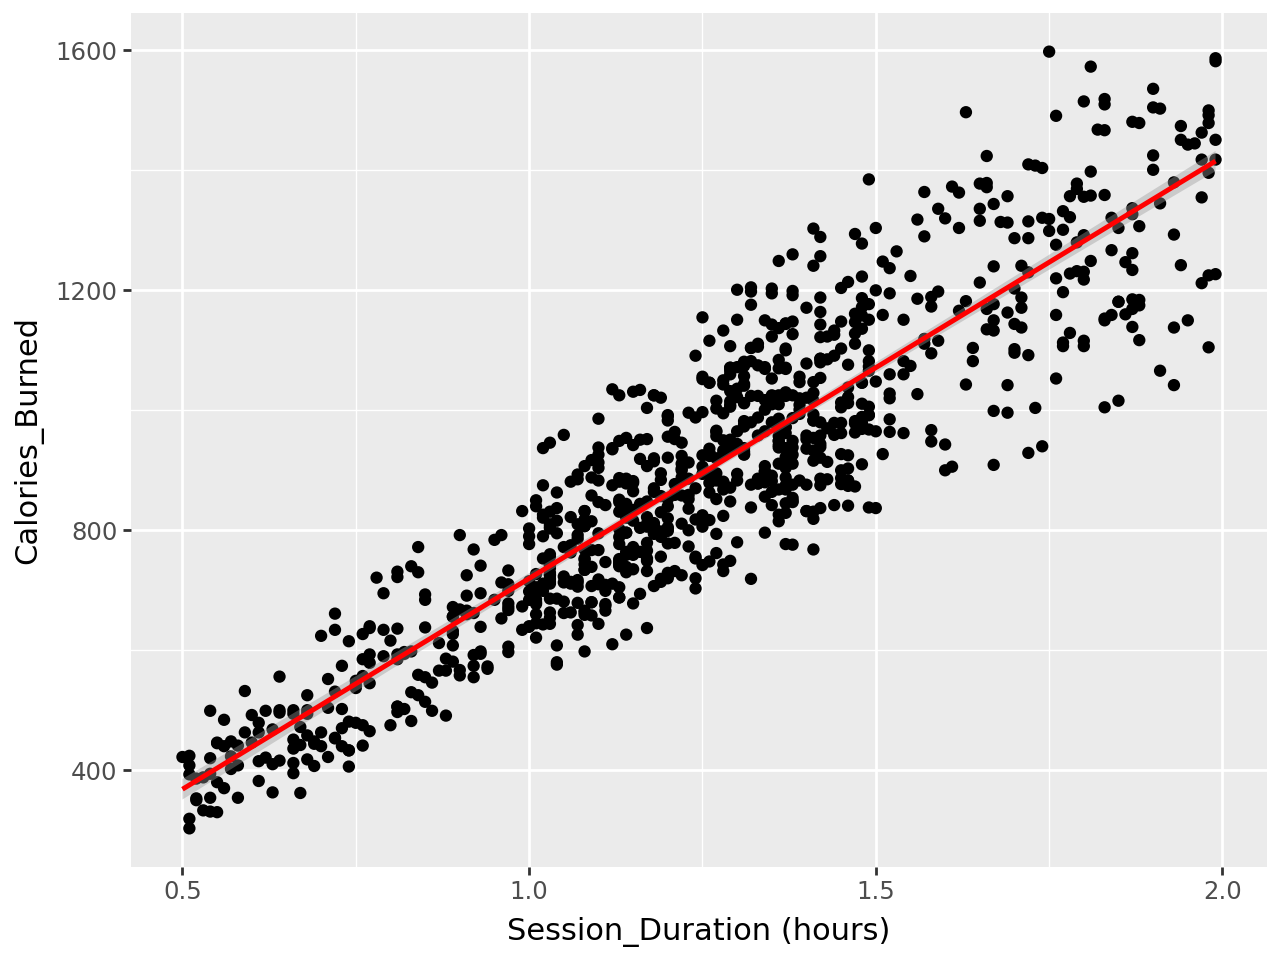

In [71]:
plt = ggplot(data, aes(x="Session_Duration (hours)", y="Calories_Burned")) + geom_point() + geom_smooth(method='lm', color='red')
display(plt)

### การแบ่งชุดข้อมูลสำหรับฝึกสอนและทดสอบ (Train-Test Split) และ การปรับสเกลคุณลักษณะ (Feature Scaling)

โครงข่ายประสาทเทียม (Neural Networks) และอัลกอริทึม Machine Learning อื่นๆ หลายตัวทำงานได้ดีขึ้นและฝึกสอนได้เร็วขึ้นเมื่อคุณลักษณะนำเข้า (input features) มีสเกลใกล้เคียงกันและกระจายตัวรอบศูนย์ ในที่นี้เราจะใช้ `StandardScaler` เพื่อปรับสเกลข้อมูล ซึ่งจะแปลงข้อมูลโดยการลบค่าเฉลี่ยและหารด้วยส่วนเบี่ยงเบนมาตรฐาน ทำให้แต่ละ feature มีค่าเฉลี่ยเป็น 0 และส่วนเบี่ยงเบนมาตรฐานเป็น 1

In [72]:
X = data.drop('Calories_Burned', axis=1)
y = data['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_test = y_test.reset_index(drop=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

กระบวนการปรับสเกล:
* **`scaler = StandardScaler()`**: สร้างอินสแตนซ์ของ `StandardScaler`
* **`X_train_scaled = scaler.fit_transform(X_train)`**: คำนวณค่าเฉลี่ย (mean) และส่วนเบี่ยงเบนมาตรฐาน (standard deviation) จาก **ชุดข้อมูลฝึกสอน (`X_train`) เท่านั้น** (เรียกว่าการ `fit`) จากนั้นจึงใช้ค่าเหล่านี้ในการแปลง (ปรับสเกล) ข้อมูล `X_train` (เรียกว่าการ `transform`)
* **`X_test_scaled = scaler.transform(X_test)`**: ใช้ค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานที่คำนวณได้จาก `X_train` (จากขั้นตอน `fit` ก่อนหน้า) มาแปลงข้อมูล **ชุดข้อมูลทดสอบ (`X_test`)** การทำเช่นนี้เป็นการป้องกันการรั่วไหลของข้อมูล (data leakage) จากชุดทดสอบไปยังกระบวนการเรียนรู้ของโมเดล ทำให้การประเมินผลมีความน่าเชื่อถือมากขึ้น
*มีการตรวจสอบว่า `X_train` และ `X_test` ไม่ใช่ DataFrame ที่ว่างเปล่าก่อนที่จะดำเนินการปรับสเกล

กำหนดค่า seed สำหรับ TensorFlow ในโหมด Compatibility v1 เพื่อควบคุมความสุ่มและทำให้ผลลัพธ์ที่ได้จากการทำงานซ้ำได้ (reproducible)

In [73]:
tf.compat.v1.set_random_seed(seed_value)

##การใช้เทคนิค K-Fold Cross-Validation เพื่อประเมินประสิทธิภาพของแบบจำลองโครงข่ายประสาทเทียมอย่างแข็งแกร่งและลดปัญหา Overfitting [3].

*   **`kf = KFold(n_splits=5, shuffle=True, random_state=42)`:** สร้าง object `KFold` กำหนดให้แบ่งข้อมูลออกเป็น 5 ส่วน (`n_splits=5`) ทำการสุ่มก่อนแบ่ง (`shuffle=True`) และกำหนดค่า `random_state` เพื่อให้ผลการแบ่งซ้ำได้
*   **`mse_scores = []`:** สร้าง list เปล่าสำหรับเก็บค่า MSE จากแต่ละ Fold
*   **วนลูปผ่านแต่ละ Fold:**
    *   แบ่งข้อมูล (`X`, `y`) ตาม index ที่ได้จาก `kf.split()` ออกเป็นชุดฝึกสอน (train) และชุดตรวจสอบ (validation) สำหรับ Fold นั้นๆ
    *   ปรับสเกลข้อมูลในชุดฝึกสอนและชุดตรวจสอบของ Fold ปัจจุบันโดยใช้ `StandardScaler` เพื่อให้ข้อมูลอยู่ในสเกลเดียวกัน
    *   สร้างและคอมไพล์แบบจำลองโครงข่ายประสาทเทียม (`Sequential` model) โดยมี layer Dense หลายๆ ชั้น พร้อม activation function 'relu' และ output layer แบบ Dense ที่ไม่มี activation function (สำหรับปัญหา Regression) ใช้ optimizer Adam และ loss เป็น 'mean_squared_error'
    *   ฝึกสอนแบบจำลองบนข้อมูลชุดฝึกสอนของ Fold นั้นๆ เป็นเวลา 100 epoch
    *   ประเมินแบบจำลองบนข้อมูลชุดตรวจสอบของ Fold นั้นๆ และเก็บค่า MSE ที่ได้ไว้ใน list `mse_scores`
*   **พิมพ์ผลลัพธ์:** แสดงค่าเฉลี่ยของ MSE, R2 ที่ได้จากทุก Fold ของ K-Fold Cross-Validation

ขั้นตอนนี้ช่วยให้ได้ค่าประเมินประสิทธิภาพของแบบจำลอง Neural Network ที่มีความน่าเชื่อถือมากขึ้น เนื่องจากได้ทดสอบแบบจำลองบนข้อมูลที่หลากหลายส่วนของชุดข้อมูลทั้งหมด

In [74]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    scaler_fold = StandardScaler()
    X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler_fold.transform(X_val_fold)
    print(X_train_fold_scaled.shape[1])

    model_fold = Sequential([
        Dense(512, activation='relu', input_shape=(X_train_fold_scaled.shape[1],)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    optimizer_fold = tf.keras.optimizers.Adam(learning_rate=0.001)
    model_fold.compile(optimizer=optimizer_fold, loss='mean_squared_error', metrics=['mean_squared_error'])

    model_fold.fit(X_train_fold_scaled, y_train_fold, epochs=100, verbose=0)

    loss_fold, mse_fold = model_fold.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)
    mse_scores.append(mse_fold)

    y_pred_fold = model_fold.predict(X_val_fold_scaled)
    r2_fold = r2_score(y_val_fold, y_pred_fold)
    r2_scores.append(r2_fold)

print(f'Average Mean Squared Error (K-Fold): {np.mean(mse_scores)}')
print(f'Average R2 Score (K-Fold): {np.mean(r2_scores)}')

13


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


13


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


13
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Average Mean Squared Error (K-Fold): 1028.111376953125
Average R2 Score (K-Fold): 0.9848806056320912


## การสร้างและฝึกสอนแบบจำลองโครงข่ายประสาทเทียม (Neural Network) ขั้นสุดท้าย โดยใช้ชุดข้อมูลฝึกสอนที่ปรับสเกลแล้ว และแสดงกราฟของ Training Loss และ Validation Loss เพื่อติดตามกระบวนการเรียนรู้

ขั้นตอนการทำงาน:
1.  **สร้างแบบจำลอง (Build Model):** สร้างแบบจำลองโครงข่ายประสาทเทียมแบบ Sequential ซึ่งประกอบด้วยชั้น Dense หลายชั้น แต่ละชั้นใช้ ReLU activation function ยกเว้นชั้นสุดท้ายที่ไม่มี activation (เหมาะสำหรับปัญหา Regression) กำหนด `input_shape` ให้ตรงกับจำนวน feature ในข้อมูล
2.  **คอมไพล์แบบจำลอง (Compile Model):** กำหนด optimizer (Adam with learning rate 0.001), loss function ('mean_squared_error') และ metrics ที่ต้องการติดตาม ('mean_squared_error') สำหรับการฝึกสอนแบบจำลอง
3.  **ฝึกสอนแบบจำลอง (Train Model):**
    *   ใช้เมธอด `fit()` เพื่อฝึกสอนแบบจำลองด้วยข้อมูลฝึกสอนที่ปรับสเกลแล้ว (`X_train_scaled`, `y_train`)
    *   `epochs=100`: ฝึกสอนเป็นจำนวน 100 รอบ
    *   `verbose=1`: แสดงแถบความคืบหน้าของการฝึกสอน
    *   `validation_split=0.2`: แบ่งข้อมูลจาก `X_train_scaled` และ `y_train` ออกมา 20% เพื่อใช้เป็นชุดข้อมูลตรวจสอบ (validation set) ในระหว่างการฝึกสอน ซึ่งจะช่วยประเมินประสิทธิภาพของโมเดลบนข้อมูลที่ไม่ได้ใช้ในการอัปเดตน้ำหนักโดยตรง
    *   ผลลัพธ์ของการฝึกสอน (ค่า loss และ metrics ในแต่ละ epoch สำหรับ training และ validation) จะถูกเก็บไว้ใน object ชื่อ `history`.
4.  **แสดงกราฟ Loss (Plot Loss):**
    *   นำเข้าไลบรารี `matplotlib.pyplot` สำหรับสร้างกราฟ
    *   พลอตกราฟเส้นของค่า Loss สำหรับชุดฝึกสอน (`history.history['loss']`) และชุดตรวจสอบ (`history.history['val_loss']`) เทียบกับจำนวน epoch
    *   กำหนดชื่อกราฟ (title), ชื่อแกน (labels) และคำอธิบายกราฟ (legend)
    *   `plt.show()`: แสดงกราฟที่สร้างขึ้น

กราฟที่ได้จะช่วยให้เห็นแนวโน้มของ loss ทั้งบนชุดฝึกสอนและชุดตรวจสอบ ซึ่งเป็นประโยชน์ในการตรวจจับปัญหา เช่น overfitting (Training Loss ลดลงเรื่อยๆ แต่ Validation Loss เริ่มสูงขึ้น)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 861254.0625 - mean_squared_error: 861254.0625 - val_loss: 833456.6250 - val_mean_squared_error: 833456.6250
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 688419.4375 - mean_squared_error: 688419.4375 - val_loss: 152561.5000 - val_mean_squared_error: 152561.5000
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 95711.8047 - mean_squared_error: 95711.8047 - val_loss: 39606.6562 - val_mean_squared_error: 39606.6562
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 46636.8945 - mean_squared_error: 46636.8945 - val_loss: 29507.1504 - val_mean_squared_error: 29507.1504
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25693.4453 - mean_squared_error: 25693.4453 - val_loss: 21273.2598 - val_mean_squared_error: 21273.2598
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16777.9199 - mean_squared_error: 16777.9199 - val_loss: 16796.7734 - val_mean_squared_error: 16796.7734
Epoch 7/100
19/19 ━━━━━━

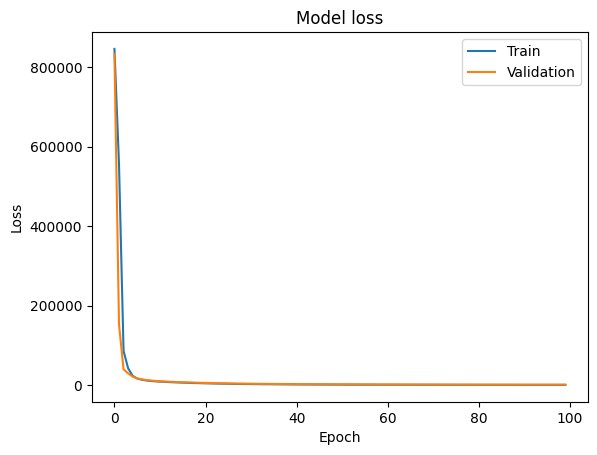

In [75]:
final_model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train_fold_scaled.shape[1],)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
])
final_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
final_model.compile(optimizer=final_optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

history = final_model.fit(X_train_scaled, y_train, epochs=100, verbose=1, validation_split=0.2)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

ใช้แบบจำลองโครงข่ายประสาทเทียมที่ฝึกสอนเสร็จแล้วทำนายปริมาณแคลอรี่ที่ถูกเผาผลาญบนชุดข้อมูลทดสอบที่ปรับสเกลแล้ว (`X_test_scaled`) และแสดงผลการเปรียบเทียบระหว่างค่าจริง (`y_test`) กับค่าที่ทำนายได้ (`y_pred_nn`) พร้อมค่าความแตกต่าง สำหรับ 10 ตัวอย่างแรกในชุดทดสอบ

In [76]:
y_pred_nn = final_model.predict(X_test_scaled)
for i in range(10):
  print(y_test[i], y_pred_nn[i], "diff : ", abs(y_test[i] - y_pred_nn[i]))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1242.0 [1245.3108] diff :  [3.310791]
777.0 [787.5656] diff :  [10.565613]
904.0 [951.252] diff :  [47.252014]
1107.0 [1092.2535] diff :  [14.74646]
1598.0 [1587.8395] diff :  [10.160522]
420.0 [470.3681] diff :  [50.368103]
1379.0 [1342.379] diff :  [36.62097]
1231.0 [1220.5214] diff :  [10.478638]
592.0 [571.01056] diff :  [20.98944]
1175.0 [1089.8096] diff :  [85.19043]


ผลลัพธ์ตัวอย่างที่ได้จากการใช้แบบจำลองโครงข่ายประสาทเทียมทำนายปริมาณแคลอรี่ที่ถูกเผาผลาญบนชุดข้อมูลทดสอบ โดยแสดงการเปรียบเทียบระหว่างค่าจริงและค่าที่ทำนายได้ พร้อมค่าความแตกต่าง สำหรับ 10 ตัวอย่างแรกในชุดทดสอบ

รูปแบบของแต่ละบรรทัดคือ: ค่าจริง | ค่าที่ทำนายได้ | ความแตกต่างสัมบูรณ์

## การทดลองทำนายผลกับข้อมูลใหม่ (Prediction on New Data)

เพื่อให้เห็นภาพการทำงานของโมเดลในทางปฏิบัติ เราจะทดสอบโมเดลกับชุดข้อมูลใหม่ (สมมติขึ้น) หนึ่งตัวอย่าง เพื่อดูว่าโมเดลจะทำนายปริมาณแคลอรี่ที่เผาผลาญได้เป็นเท่าใดสำหรับข้อมูลนำเข้านั้น

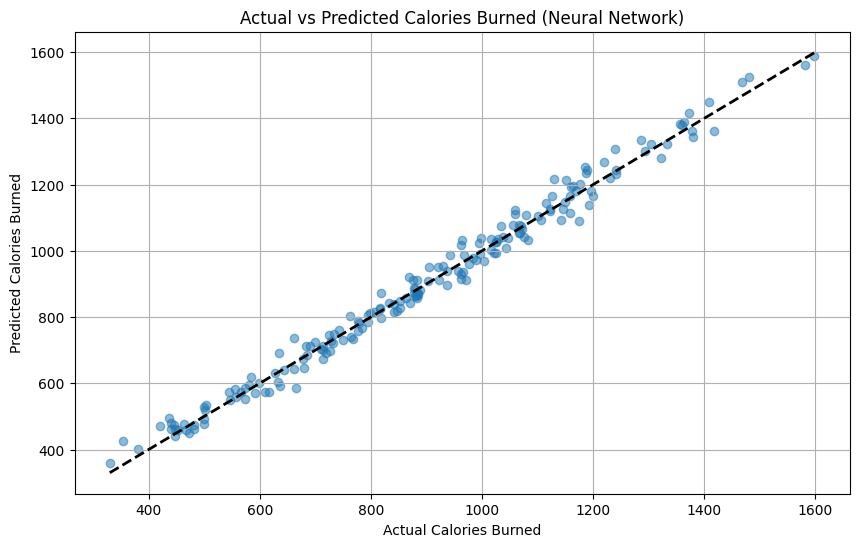

In [77]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.title('Actual vs Predicted Calories Burned (Neural Network)')
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.grid(True)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

ใช้ไลบรารี matplotlib ในการสร้างกราฟ Scatter Plot เพื่อเปรียบเทียบค่าจริง (Actual Values) กับค่าที่แบบจำลองโครงข่ายประสาทเทียมทำนายได้ (Predicted Values) บนชุดข้อมูลทดสอบ (y_test และ y_pred_nn) โดยมีขั้นตอนดังนี้:

plt.figure(figsize=(10, 6)): สร้างพื้นที่สำหรับแสดงกราฟ (figure) และกำหนดขนาดของพื้นที่นั้นให้กว้าง 10 นิ้ว และสูง 6 นิ้ว

plt.scatter(y_test, y_pred_nn, alpha=0.5): สร้าง Scatter Plot โดย:

ใช้ค่าจริงของปริมาณแคลอรี่ที่ถูกเผาผลาญจากชุดข้อมูลทดสอบ (y_test) เป็นค่าบนแกนแนวนอน (x-axis)
ใช้ค่าที่แบบจำลอง Neural Network ทำนายได้ (y_pred_nn) เป็นค่าบนแกนแนวตั้ง (y-axis)
alpha=0.5 ตั้งค่าความโปร่งใสของจุดให้เป็น 0.5 ทำให้มองเห็นจุดที่ทับซ้อนกันได้ง่ายขึ้น
plt.title('Actual vs Predicted Calories Burned (Neural Network)'): กำหนดชื่อเรื่อง (title) ของกราฟ

plt.xlabel('Actual Calories Burned'): กำหนดชื่อแกนแนวนอน (x-axis)

plt.ylabel('Predicted Calories Burned'): กำหนดชื่อแกนแนวตั้ง (y-axis)

plt.grid(True): เพิ่มเส้นตาราง (grid) ลงในกราฟ เพื่อช่วยให้อ่านค่าบนแกนได้ง่ายขึ้น

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2): พล็อตกราฟเส้นตรงในแนวทแยงมุม โดย:

เริ่มต้นจากจุดที่มีค่า x และ y เท่ากับค่าต่ำสุดของ y_test
สิ้นสุดที่จุดที่มีค่า x และ y เท่ากับค่าสูงสุดของ y_test
'k--': กำหนดให้เส้นเป็นสีดำ (k) และเป็นเส้นประ (--)
lw=2: กำหนดความหนาของเส้นเป็น 2
เส้นนี้เรียกว่าเส้น "y=x" หรือ "perfect prediction line" จุดที่อยู่บนเส้นนี้แสดงถึงกรณีที่ค่าที่ทำนายได้เท่ากับค่าจริงพอดี
plt.show(): แสดงกราฟที่สร้างขึ้นทั้งหมด